In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
import sys
sys.path.append('../../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import Fixed_QSDE, QSDE
from sdebridge.utils import *
from sdebridge.plotting import *

plt.style.use('ggplot')
rng_key = jax.random.PRNGKey(0)

In [3]:
d = 64
alpha = 0.5
sigma = 0.5

### Fixed Q

In [4]:
X0 = sample_circle(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))
init_Q = eval_Q(X0, alpha, sigma)
print(init_Q.shape)

sde_params = {
    "dimension": d,
    "num_steps": 100,
    "init_Q": init_Q
}
sde = Fixed_QSDE(sde_params=sde_params)
bridge=DiffusionBridge(sde)

(64, 64)


(1, 100, 64)


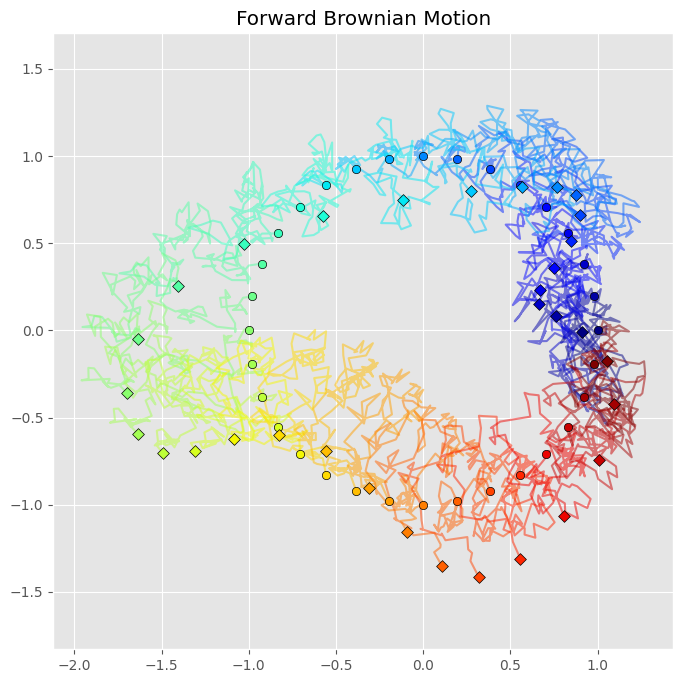

In [5]:
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    rng=jax.random.PRNGKey(0),
    num_batches=1
)
print(forward_brownian_motion["trajectories"].shape)
plot_single_trajectory(forward_brownian_motion["trajectories"][0], title="Forward Brownian Motion")

In [6]:
XT = forward_brownian_motion["trajectories"][0][-1]

In [7]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 128,
                "encoding_dim": 128,
                "act": 'gelu',
                "encoder_layer_dims": [128, 256, 128],
                "decoder_layer_dims": [128, 256, 128],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-4}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng=rng)

Training:   2%|▏         | 1/50 [00:18<14:54, 18.25s/epoch, Epoch=1, loss=261355280.0000]


KeyboardInterrupt: 

In [25]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng=rng,
                                                           num_batches=16)

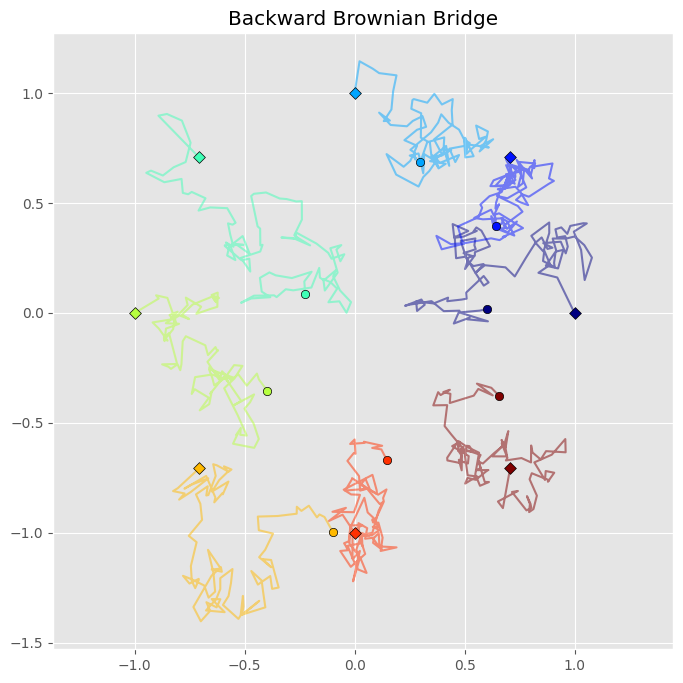

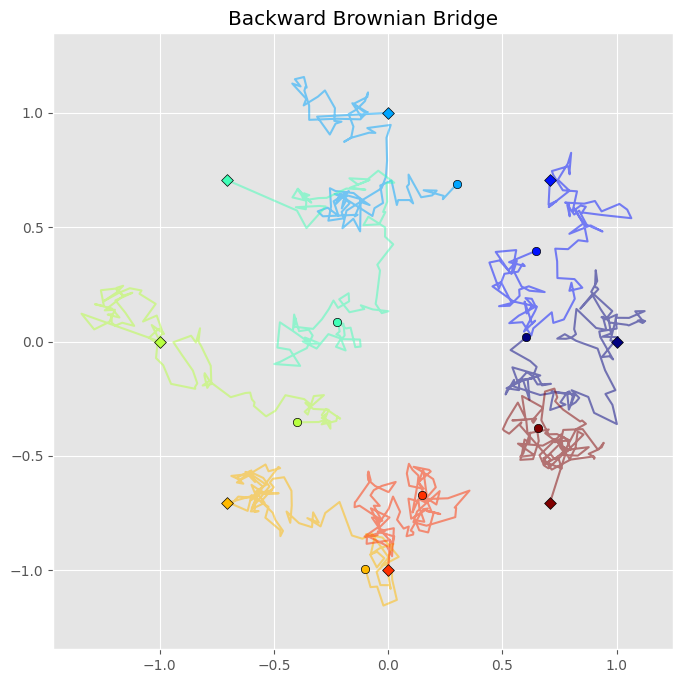

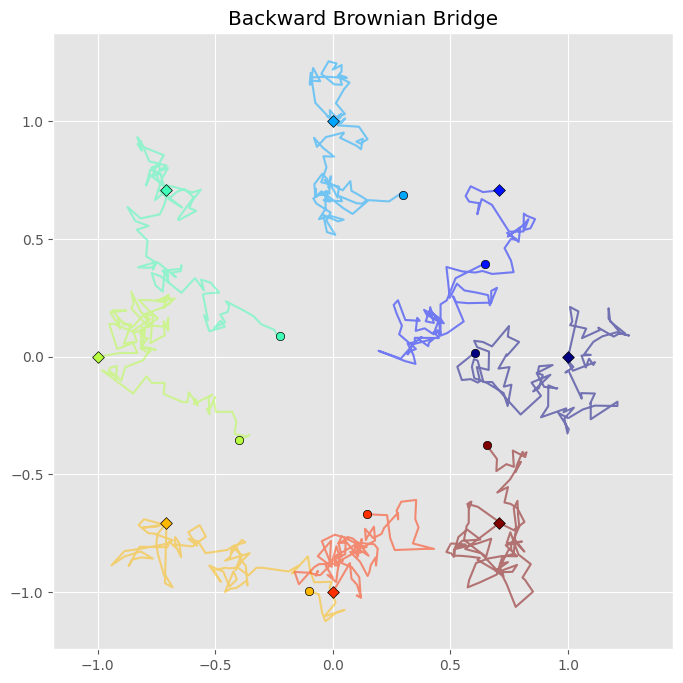

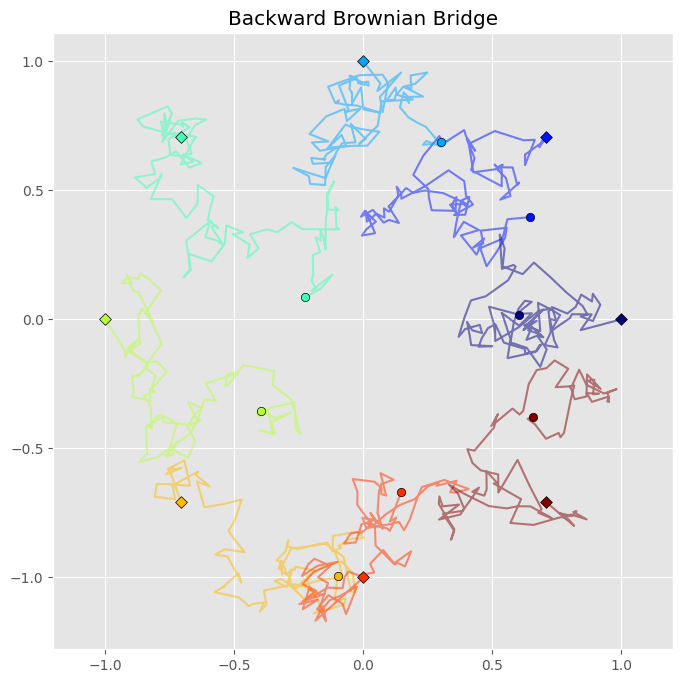

In [26]:
for i in range(4):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Brownian Bridge")

In [27]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 128,
                "encoding_dim": 128,
                "act": 'gelu',
                "encoder_layer_dims": [128, 256, 128],
                "decoder_layer_dims": [128, 64, 32],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 100,
                 "learning_rate": 5e-4}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng=rng,
                                               loss_calibration=False)

Training: 100%|██████████| 50/50 [04:13<00:00,  5.06s/epoch, Epoch=50, loss=7.4031]


In [28]:
score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0, 
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         rng=rng,
                                                         num_batches=16)

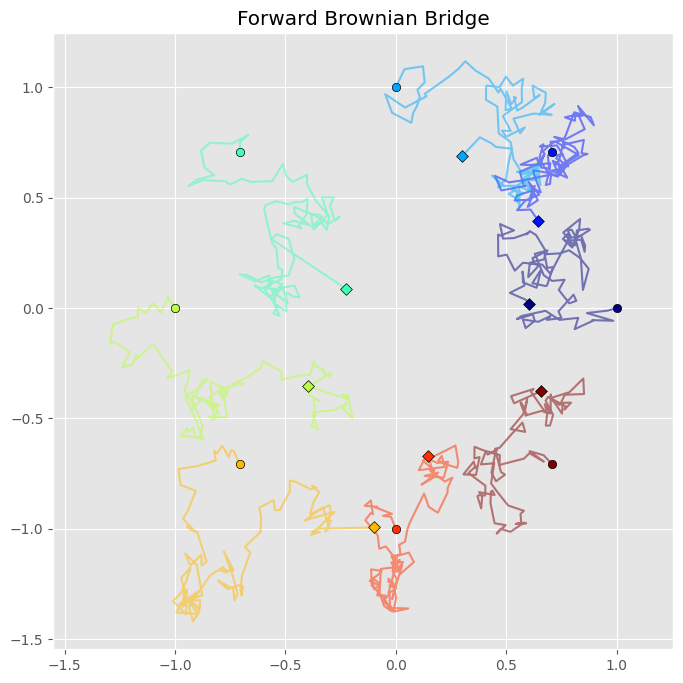

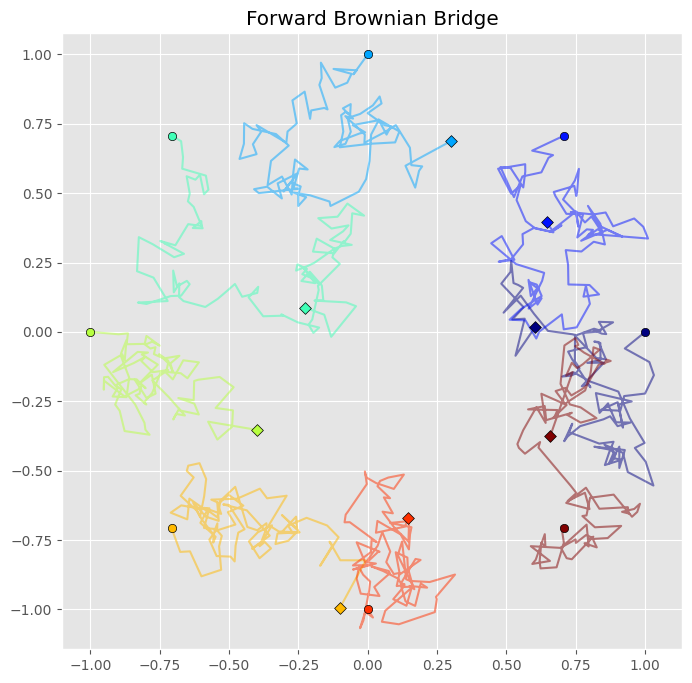

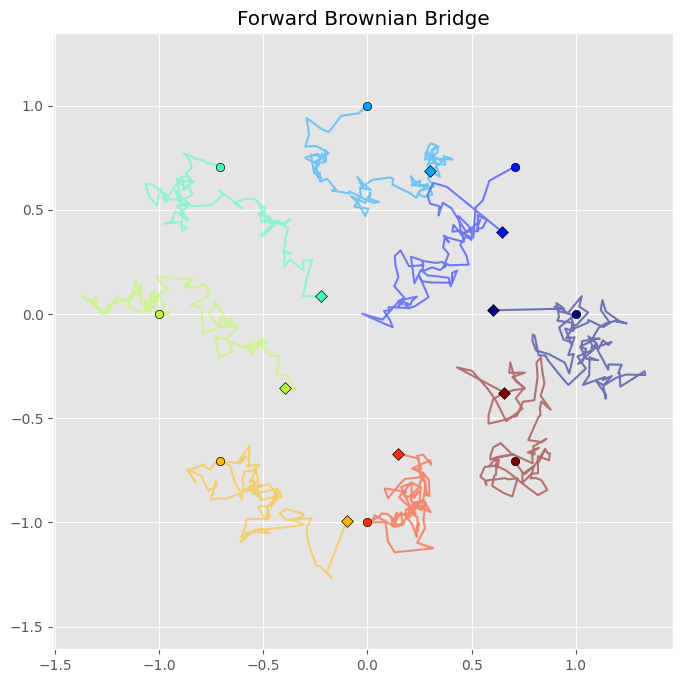

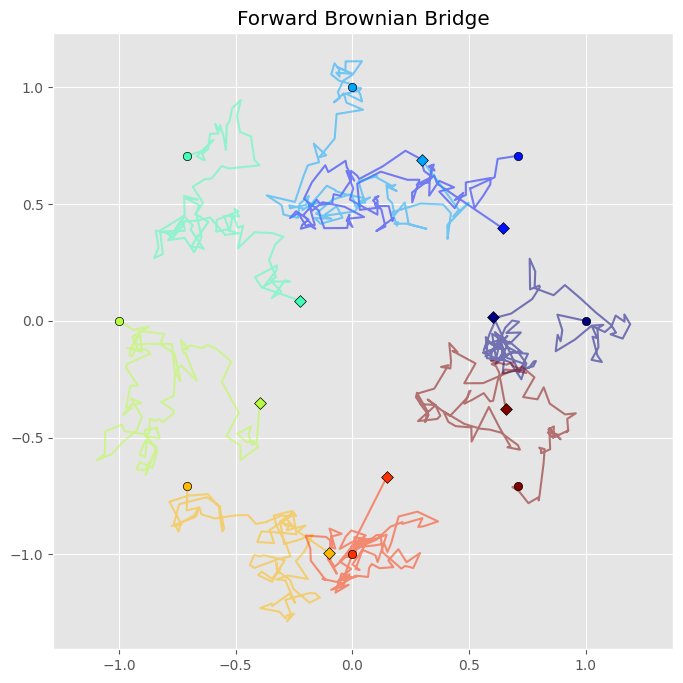

In [29]:
for i in range(4):
    plot_single_trajectory(forward_brownian_bridge["trajectories"][i], title="Forward Brownian Bridge")

### Variable Q

### 2 Landmarks

In [3]:
d = 4
alpha = 0.5
sigma = 1.0
rng = jax.random.PRNGKey(d)

sde_params = {
    "dimension": d,
    "num_steps": 100,
    "alpha": alpha,
    "sigma": sigma,
}
sde = QSDE(sde_params=sde_params)
bridge=DiffusionBridge(sde)

X0 = jnp.array([-0.5, 0.0, 0.5, 0.0])

In [4]:
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    rng=rng,
    num_batches=16
)

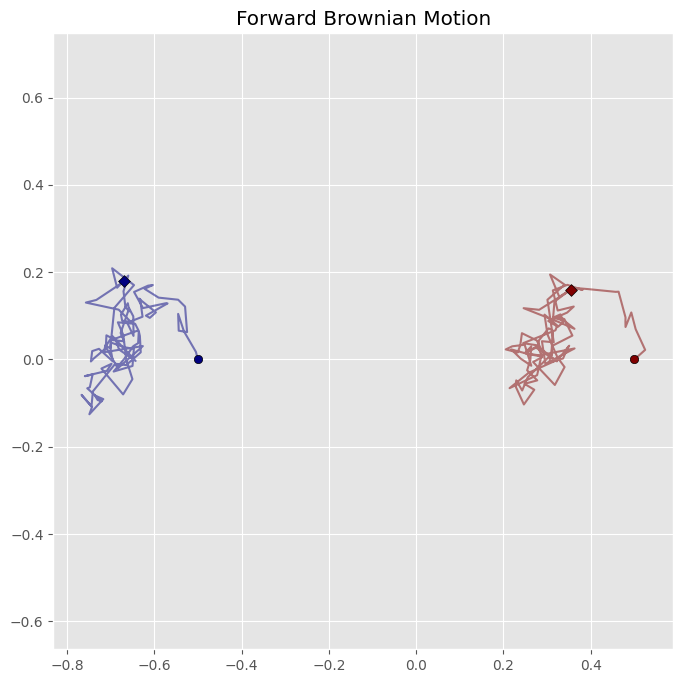

In [5]:
for i in range(1):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Brownian Motion")

In [9]:
XT = forward_brownian_motion["trajectories"][1][-1]

In [6]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 32,
                "act": 'gelu',
                "encoder_layer_dims": [64, 32, 32],
                "decoder_layer_dims": [32, 32, 32],
                "using_batchnorm": True},
    "training": {"batch_size": 64,
                 "num_epochs": 100,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 2e-4}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng=rng)

Training: 100%|██████████| 100/100 [01:15<00:00,  1.33epoch/s, Epoch=100, loss=1.8856]


In [10]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng=rng,
                                                           num_batches=16)

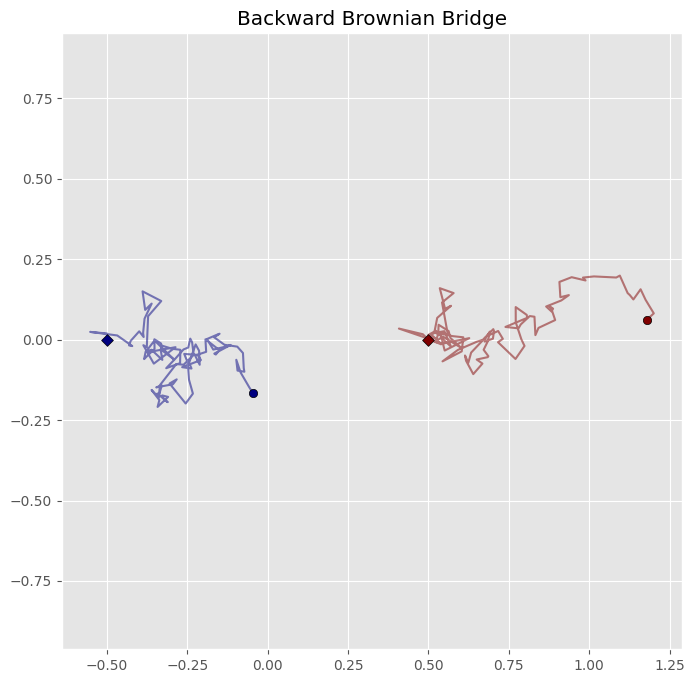

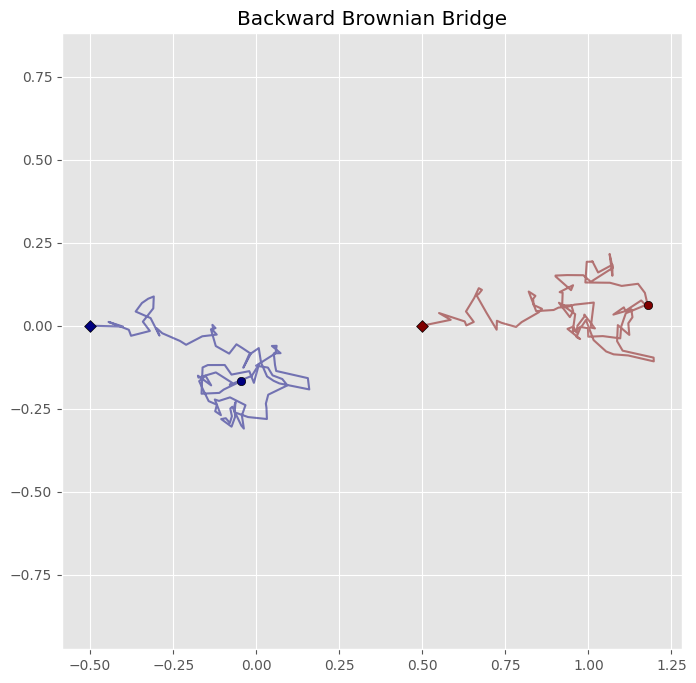

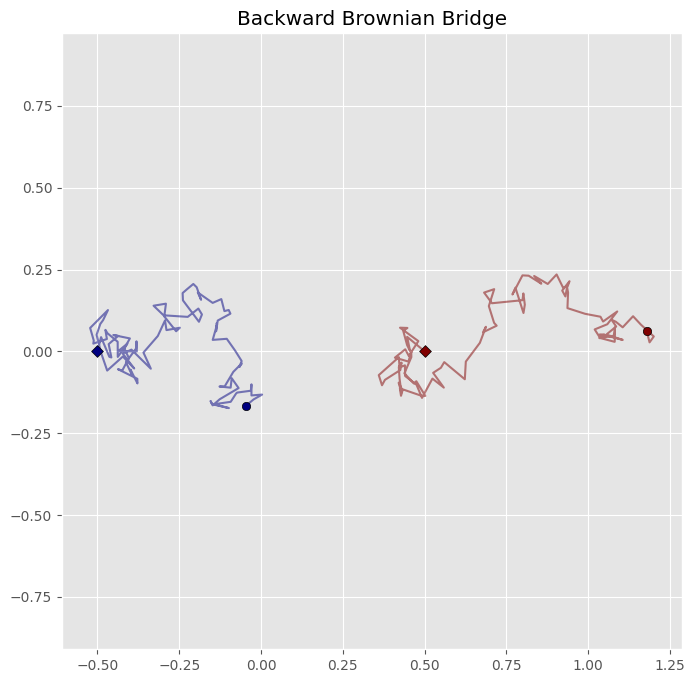

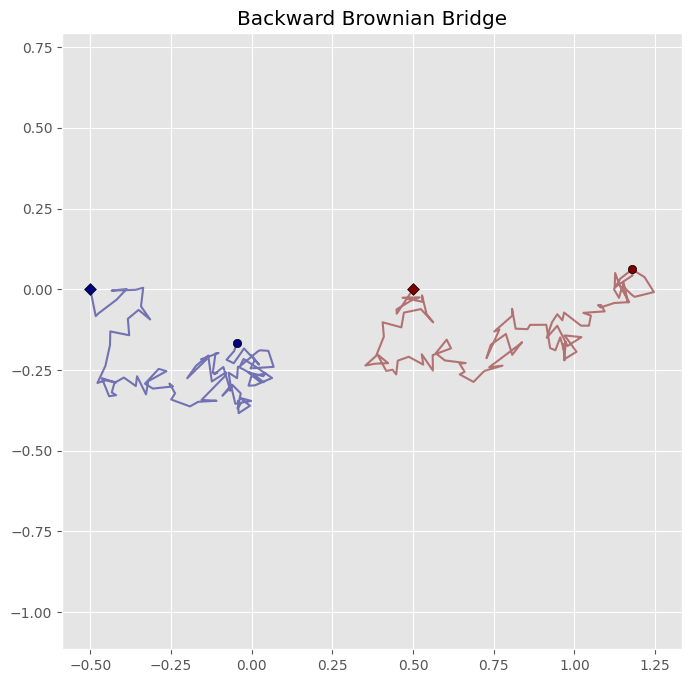

In [11]:
for i in range(4):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Brownian Bridge")

In [12]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [64, 32, 23],
                "decoder_layer_dims": [32, 32, 32],
                "using_batchnorm": True},
    "training": {"batch_size": 64,
                 "num_epochs": 100,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 2e-4}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng=rng)

Training: 100%|██████████| 100/100 [01:22<00:00,  1.22epoch/s, Epoch=100, loss=1.8086]


In [13]:
score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         rng=rng,
                                                         num_batches=4)

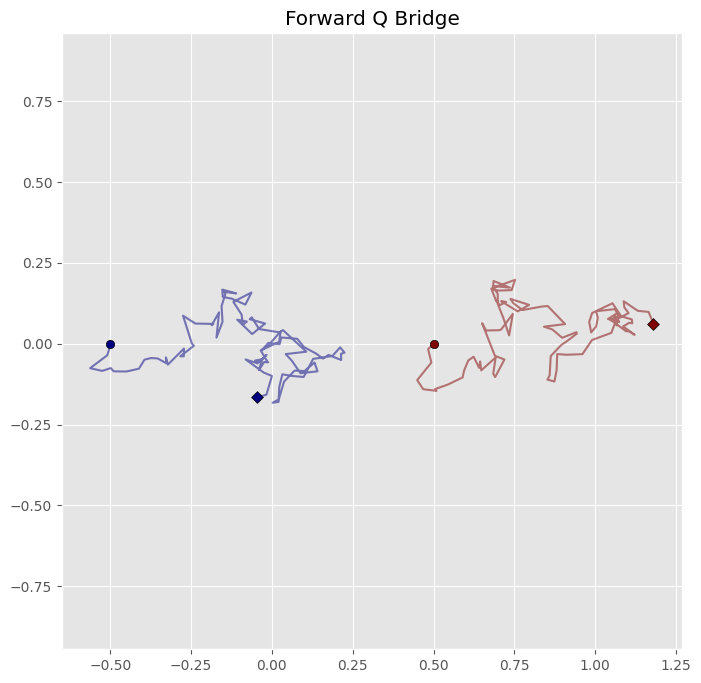

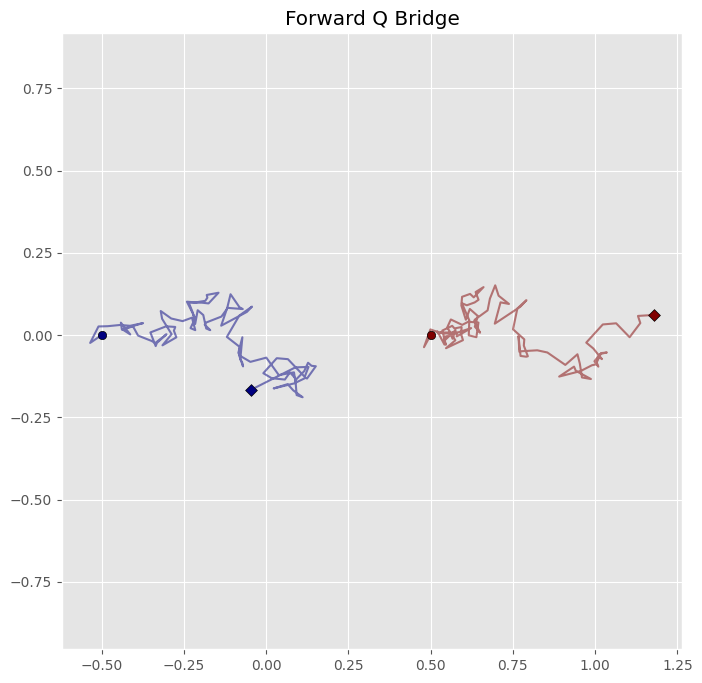

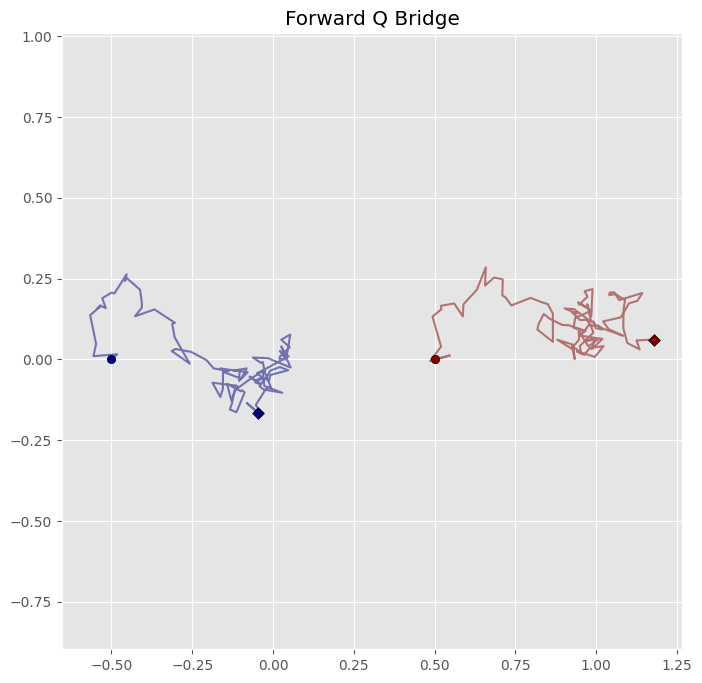

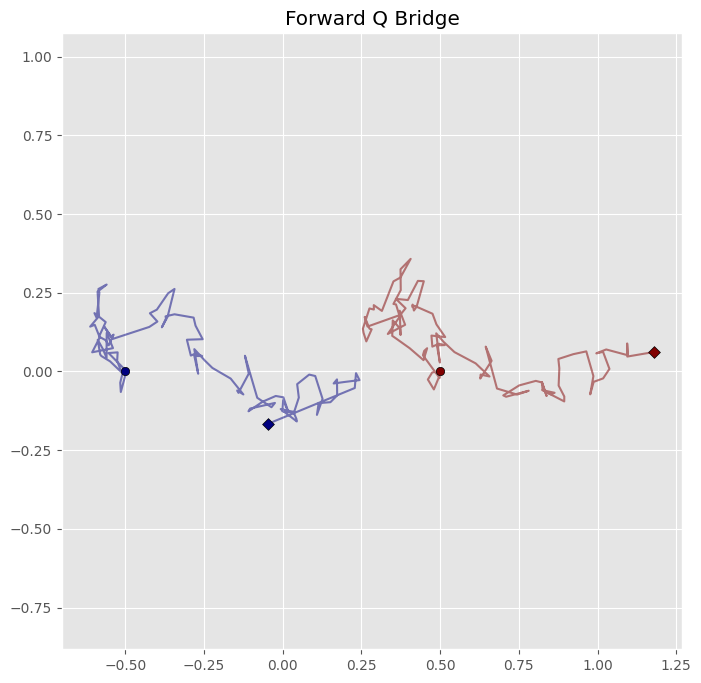

In [14]:
for i in range(4):
    plot_single_trajectory(forward_brownian_bridge["trajectories"][i], title="Forward Q Bridge")

### 4 Landmarks

In [28]:
d = 8
alpha = 0.5
sigma = 0.2
rng_key = jax.random.PRNGKey(d)

sde_params = {
    "dimension": d,
    "num_steps": 100,
    "alpha": alpha,
    "sigma": sigma,
}
sde = QSDE(sde_params=sde_params)
bridge=DiffusionBridge(sde)

X0 = jnp.array([-0.5, 0.0, 0.5, 0.0, 0.5, 1.0, -0.5, 1.0])

In [29]:
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    rng_key=rng_key,
    num_batches=1
)

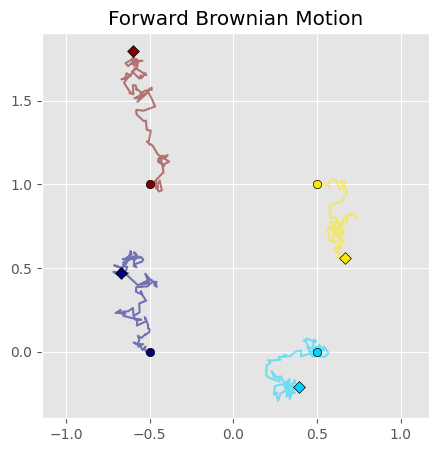

In [30]:
for i in range(1):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Brownian Motion")

In [31]:
XT = forward_brownian_motion["trajectories"][0][-1]

In [32]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'tanh',
                "encoder_layer_dims": [64, 64, 64],
                "decoder_layer_dims": [64, 64, 64],
                "using_batchnorm": True},
    "training": {"batch_size": 64,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 2e-4}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng_key=rng_key)

Training: 100%|██████████| 50/50 [01:18<00:00,  1.58s/epoch, Epoch=50, loss=3.7776]


In [33]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng_key=rng_key,
                                                           num_batches=4)

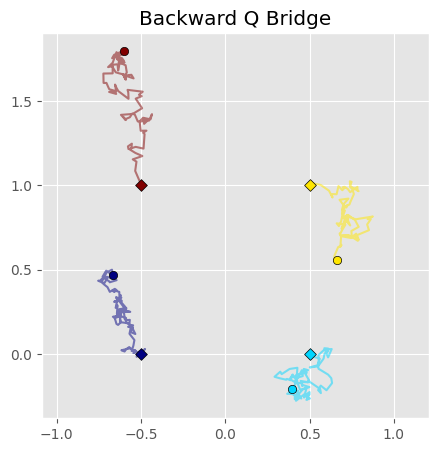

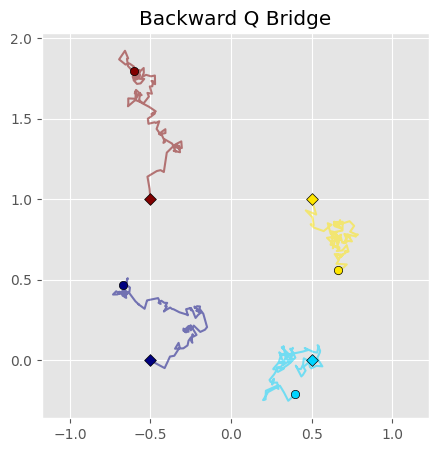

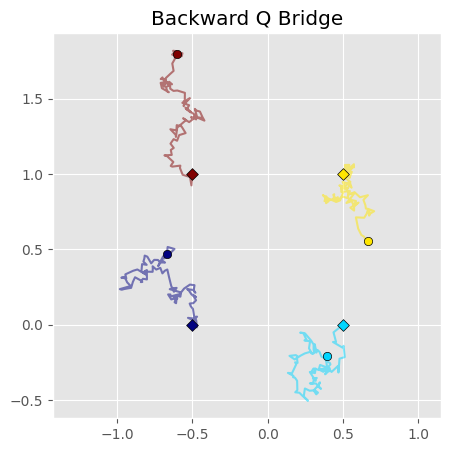

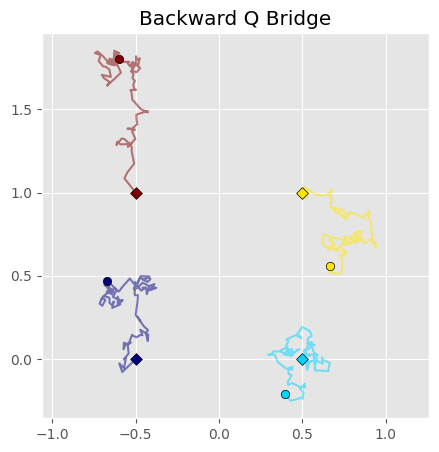

In [34]:
for i in range(4):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Q Bridge")

In [35]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'tanh',
                "encoder_layer_dims": [64, 64, 64],
                "decoder_layer_dims": [64, 64, 64],
                "using_batchnorm": True},
    "training": {"batch_size": 64,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 2e-4}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng_key=rng_key)

Training: 100%|██████████| 50/50 [02:22<00:00,  2.85s/epoch, Epoch=50, loss=4.3615]


In [36]:
score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         rng_key=rng_key,
                                                         num_batches=4)

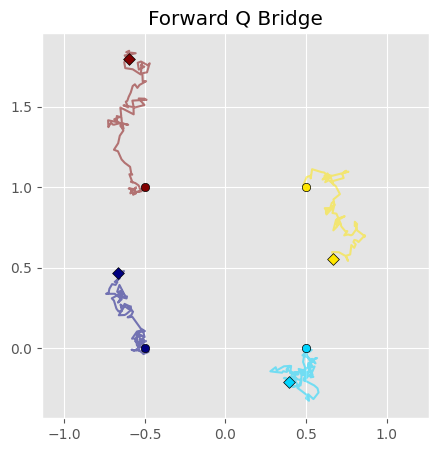

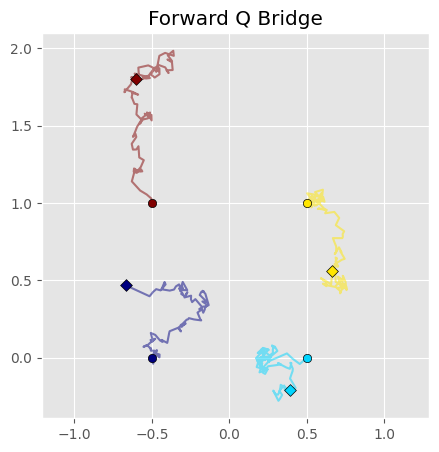

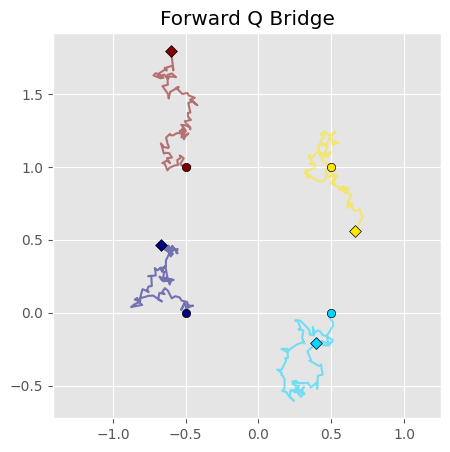

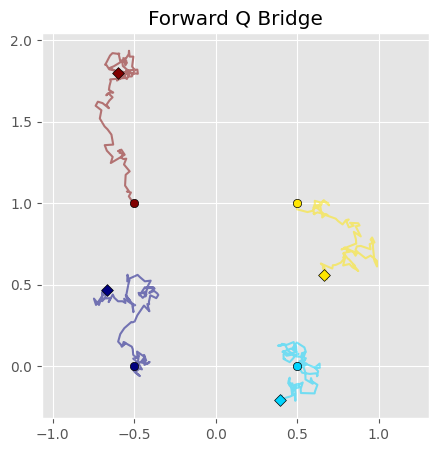

In [37]:
for i in range(4):
    plot_single_trajectory(forward_brownian_bridge["trajectories"][i], title="Forward Q Bridge")

### 8 Landmarks

In [35]:
d = 16
sigma = 1.0
sde_params = {
    "dimension": d,
    "num_steps": 100,
    "alpha": alpha,
    "sigma": sigma,
}
sde = QSDE(sde_params=sde_params)
bridge=DiffusionBridge(sde)

In [36]:
X0 = sample_ellipse(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]), a=1.0, b=1.0)
XT = sample_ellipse(num_points=d//2, scale=2.0, shifts=jnp.array([0.0, 0.0]), a=1.0, b=1.0)
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    rng_key=rng_key,
    num_batches=4
)

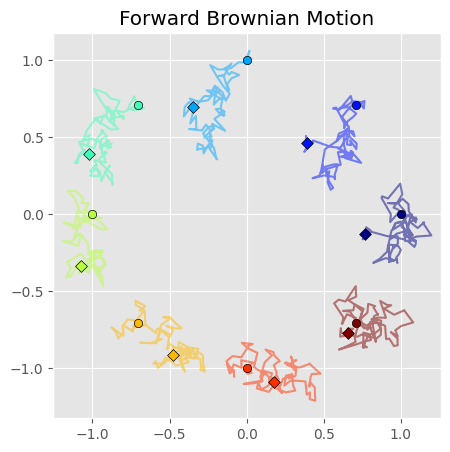

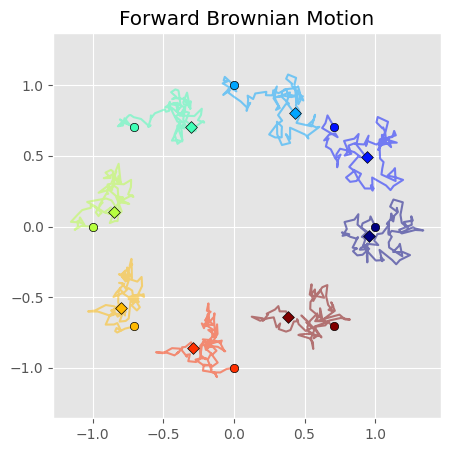

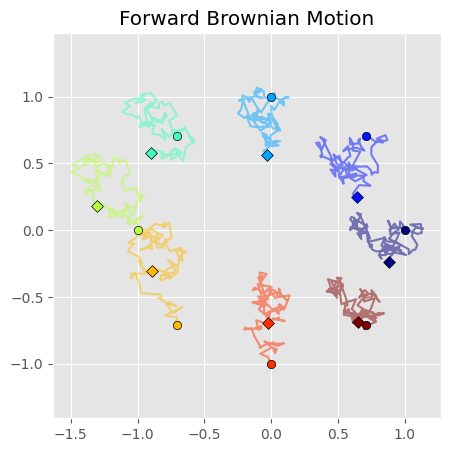

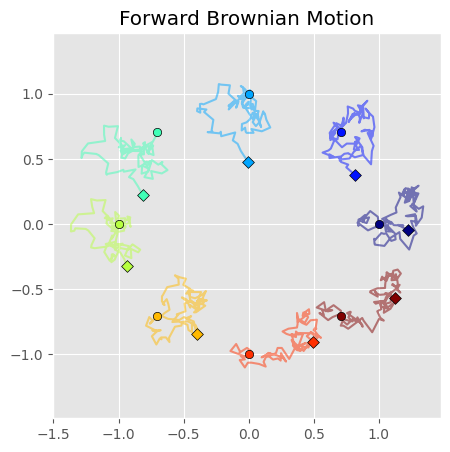

In [37]:
for i in range(4):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Brownian Motion")

In [39]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [64, 64, 64],
                "decoder_layer_dims": [64, 64, 64],
                "using_batchnorm": True},
    "training": {"batch_size": 16,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 2e-4}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng_key=rng_key,
                                     )

Training: 100%|██████████| 50/50 [01:04<00:00,  1.29s/epoch, Epoch=50, loss=7.9988]


In [42]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng_key=rng_key,
                                                           num_batches=4)

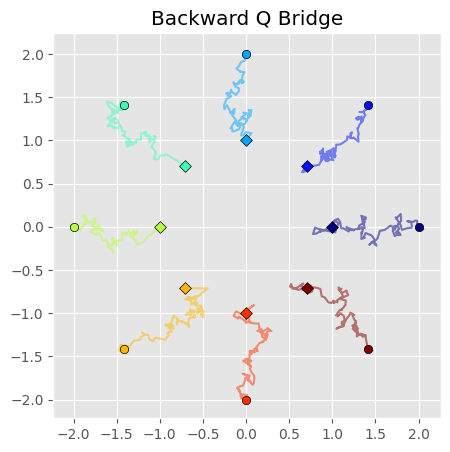

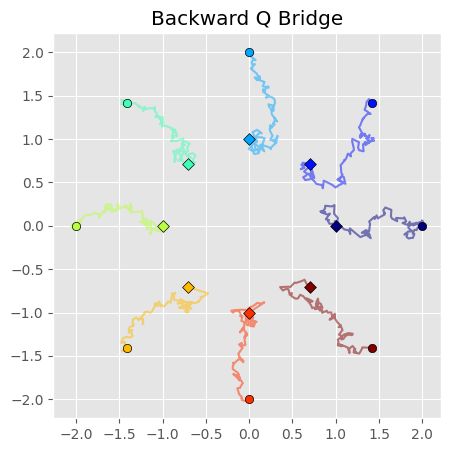

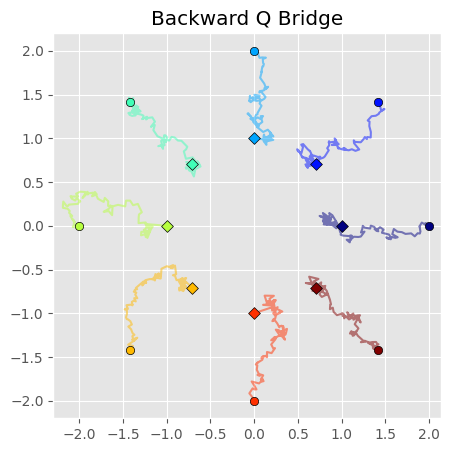

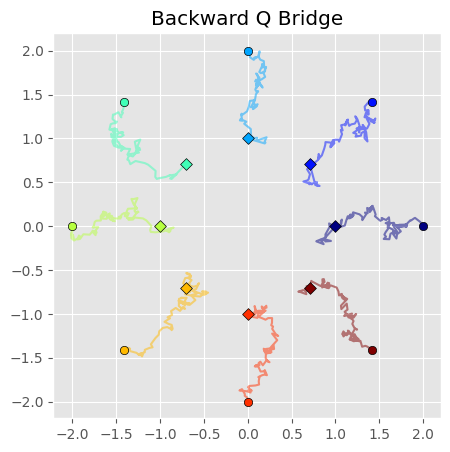

In [43]:
for i in range(4):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Q Bridge")

In [44]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [64, 64, 64],
                "decoder_layer_dims": [64, 64, 64],
                "using_batchnorm": True},
    "training": {"batch_size": 16,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 2e-4}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng_key=rng_key)

Training: 100%|██████████| 50/50 [02:38<00:00,  3.17s/epoch, Epoch=50, loss=8.1494]


In [45]:
score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         rng_key=rng_key,
                                                         num_batches=4)

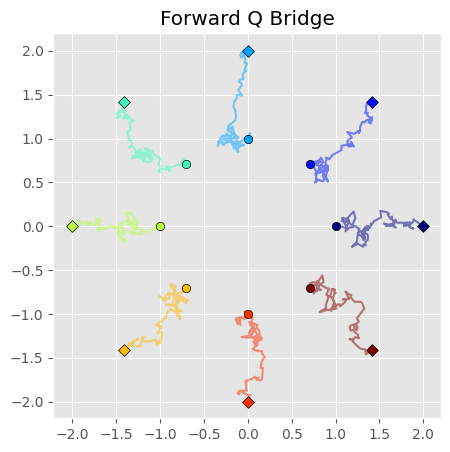

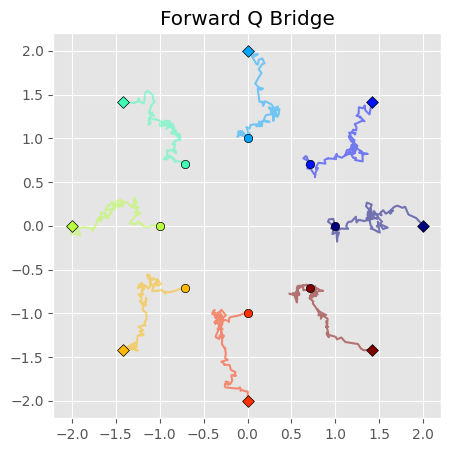

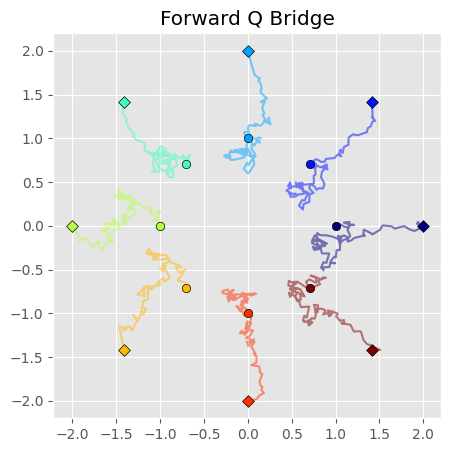

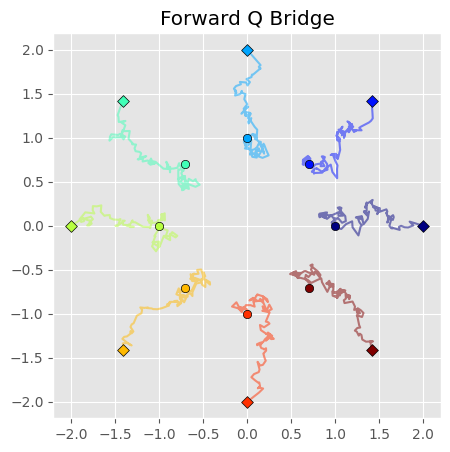

In [46]:
for i in range(4):
    plot_single_trajectory(forward_brownian_bridge["trajectories"][i], title="Forward Q Bridge")

### 16 Landmarks

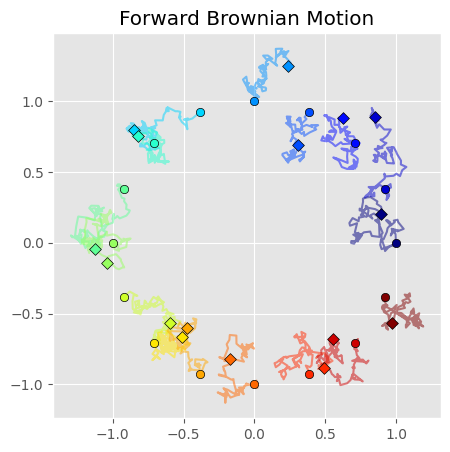

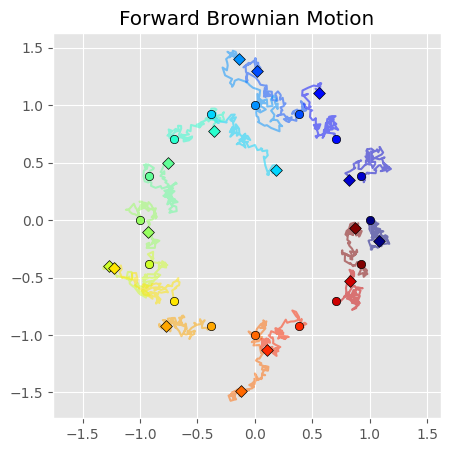

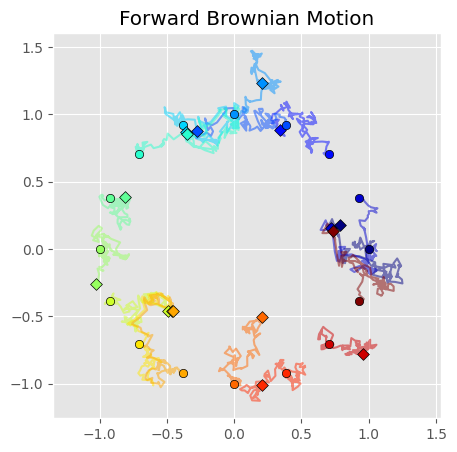

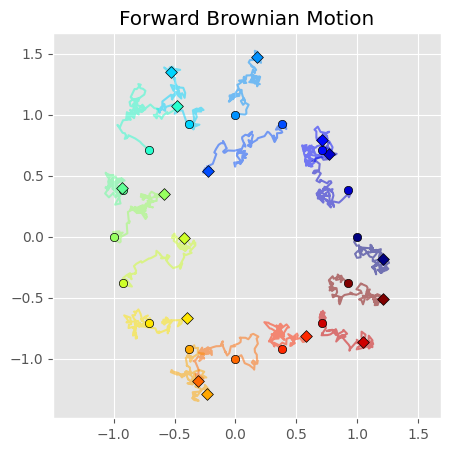

In [58]:
d = 32
sigma = 0.1
sde_params = {
    "dimension": d,
    "num_steps": 100,
    "alpha": alpha,
    "sigma": sigma,
}
sde = QSDE(sde_params=sde_params)
bridge=DiffusionBridge(sde)

X0 = sample_ellipse(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]), a=1.0, b=1.0)
XT = sample_ellipse(num_points=d//2, scale=2.0, shifts=jnp.array([0.0, 0.0]), a=1.0, b=1.0)
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    rng_key=rng_key,
    num_batches=4
)

for i in range(4):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Brownian Motion")

In [59]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [64, 64, 64],
                "decoder_layer_dims": [64, 64, 64],
                "using_batchnorm": True},
    "training": {"batch_size": 16,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 2e-4}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng_key=rng_key,
                                     )

Training:   2%|▏         | 1/50 [00:11<09:21, 11.46s/epoch, Epoch=1, loss=nan]


KeyboardInterrupt: 

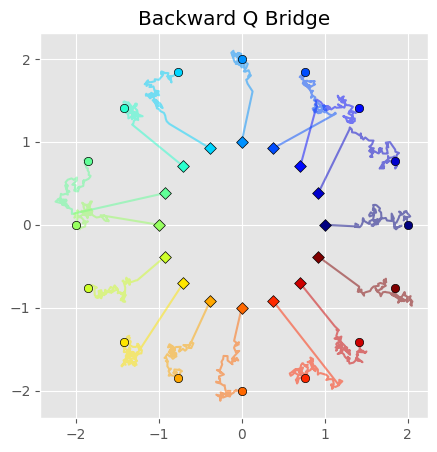

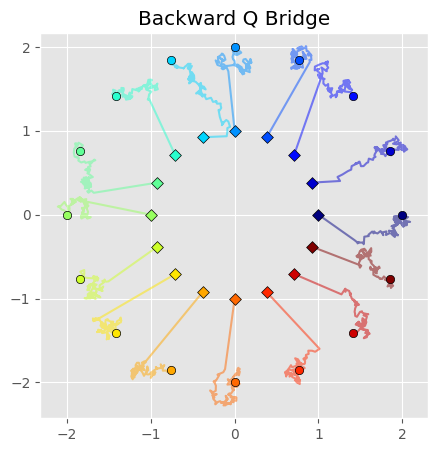

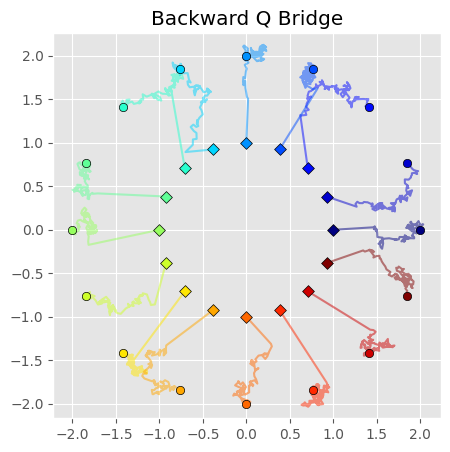

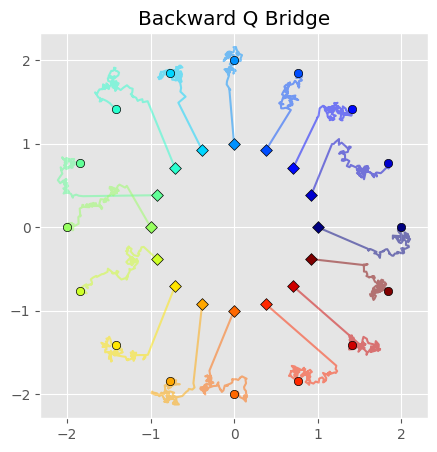

In [57]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng_key=rng_key,
                                                           num_batches=4)
for i in range(4):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Q Bridge")